In [1]:
import pandas as pd
import psycopg2

In [2]:
import matplotlib.pyplot as plt

In [3]:
conn = psycopg2.connect(
    host="localhost",
    database="Ecommerce",
    user="postgres",
    password="mariam54"
)

cursor = conn.cursor()


In [4]:
cursor.execute("""SELECT column_name, data_type
FROM information_schema.columns
WHERE table_name = 'sales';
""")

In [5]:
rows=cursor.fetchall()

In [6]:
for row in rows:
    print(row)

('sales', 'numeric')
('quantity', 'integer')
('discount', 'numeric')
('profit', 'numeric')
('shipping_cost', 'numeric')
('aging', 'numeric')
('order_date', 'date')
('product', 'text')
('order_priority', 'text')
('payment_method', 'text')
('time', 'text')
('customer_id', 'text')
('gender', 'text')
('device_type', 'text')
('customer_login_type', 'text')
('product_category', 'text')


In [7]:
try:
    cursor.execute("""
    UPDATE sales SET 
    gender = TRIM(gender),
    device_type = TRIM(device_type),
    customer_login_type = TRIM(customer_login_type),
    product_category = TRIM(product_category),
    product = TRIM(product),
    order_priority = TRIM(order_priority),
    payment_method = TRIM(payment_method);""")

    cursor.execute("""
    UPDATE sales SET
    sales = NULLIF(sales::text, '')::numeric,
    quantity = NULLIF(quantity::text, '')::numeric,
    discount = NULLIF(discount::text, '')::numeric,
    profit = NULLIF(profit::text, '')::numeric,
    shipping_cost = NULLIF(shipping_cost::text, '')::numeric;""")
    conn.commit()

except Exception as e:
    conn.rollback()
    print("Error:", e)

In [8]:
try:
    cursor.execute("""UPDATE sales SET 
    aging = (
    SELECT AVG(aging)
    FROM sales)
    WHERE aging IS NULL;""")
    
    cursor.execute("""UPDATE sales SET 
    shipping_cost = (
    SELECT AVG(shipping_cost)
    FROM sales)
    WHERE shipping_cost IS NULL;""")
    
    cursor.execute("""UPDATE sales SET 
    discount = 0
    WHERE discount IS NULL;""")
    
    cursor.execute("""UPDATE sales SET 
    order_priority = (
    SELECT order_priority
    FROM sales
    WHERE order_priority IS NOT NULL
    GROUP BY order_priority
    ORDER BY COUNT(*) DESC
    LIMIT 1)
    WHERE order_priority IS NULL;""")
except Exception as e:
    conn.rollback()
    print("Error:", e)

In [9]:
cursor.execute("SELECT * FROM sales;")
rows = cursor.fetchall()
columns = [desc[0] for desc in cursor.description]

In [10]:
df = pd.DataFrame(rows, columns=columns)

In [11]:
cursor.close()
conn.close()

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   order_date           51290 non-null  object
 1   time                 51290 non-null  object
 2   aging                51290 non-null  object
 3   customer_id          51290 non-null  object
 4   gender               51290 non-null  object
 5   device_type          51290 non-null  object
 6   customer_login_type  51290 non-null  object
 7   product_category     51290 non-null  object
 8   product              51290 non-null  object
 9   sales                51290 non-null  object
 10  quantity             51290 non-null  int64 
 11  discount             51290 non-null  object
 12  profit               51290 non-null  object
 13  shipping_cost        51290 non-null  object
 14  order_priority       51290 non-null  object
 15  payment_method       51290 non-null  object
dtypes: i

In [13]:
df.duplicated().sum()

np.int64(0)

In [14]:
df['order_date'] = pd.to_datetime(df['order_date'], errors='coerce')

In [15]:
df['sales']=pd.to_numeric(df['sales'], errors='coerce')
df['discount']=pd.to_numeric(df['discount'], errors='coerce')
df['profit']=pd.to_numeric(df['profit'], errors='coerce')
df['shipping_cost']=pd.to_numeric(df['shipping_cost'], errors='coerce')

In [16]:
df['aging']=pd.to_numeric(df['aging'], errors='coerce')

In [17]:
df['time'] = pd.to_datetime(df['time'], format='%H:%M:%S', errors='coerce').dt.time

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   order_date           51290 non-null  datetime64[ns]
 1   time                 51290 non-null  object        
 2   aging                51290 non-null  float64       
 3   customer_id          51290 non-null  object        
 4   gender               51290 non-null  object        
 5   device_type          51290 non-null  object        
 6   customer_login_type  51290 non-null  object        
 7   product_category     51290 non-null  object        
 8   product              51290 non-null  object        
 9   sales                51290 non-null  float64       
 10  quantity             51290 non-null  int64         
 11  discount             51290 non-null  float64       
 12  profit               51290 non-null  float64       
 13  shipping_cost        51290 non-

In [19]:
num_cols = ['sales', 'quantity', 'discount', 'profit', 'shipping_cost', 'aging']

In [20]:
df[num_cols].skew()

sales           -0.087924
quantity         0.464177
discount         0.033109
profit           0.260969
shipping_cost    0.262504
aging            0.065586
dtype: float64

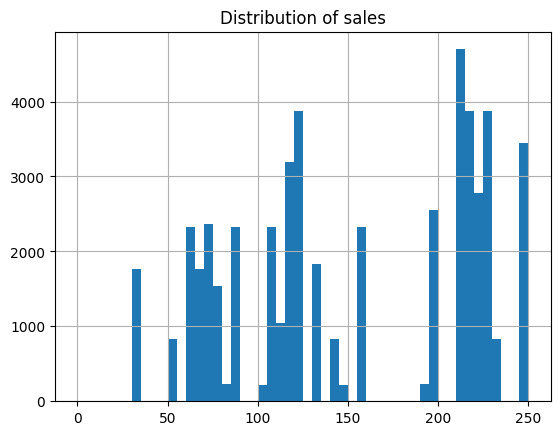

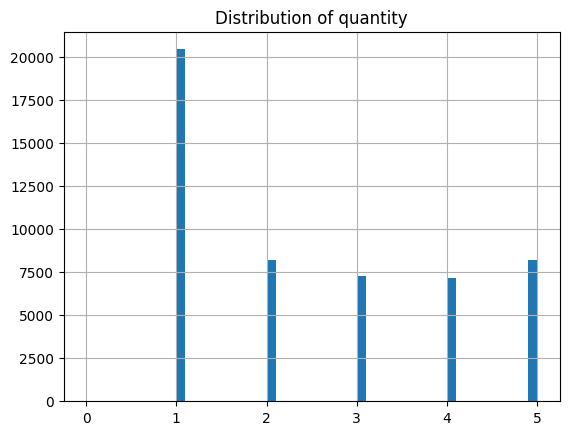

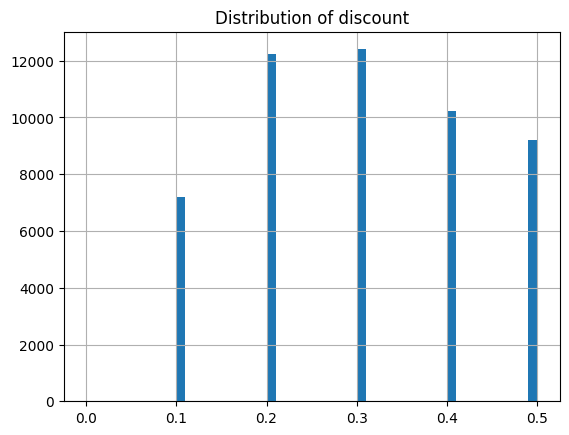

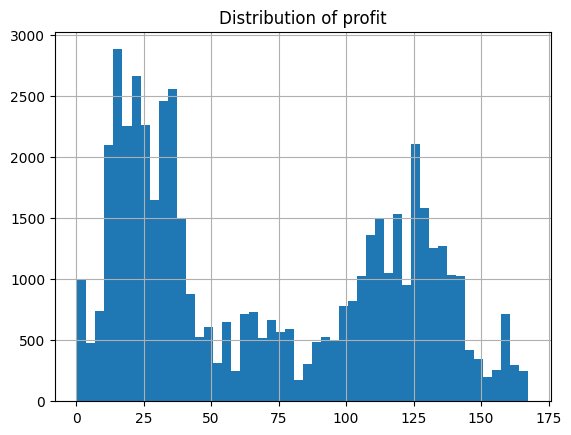

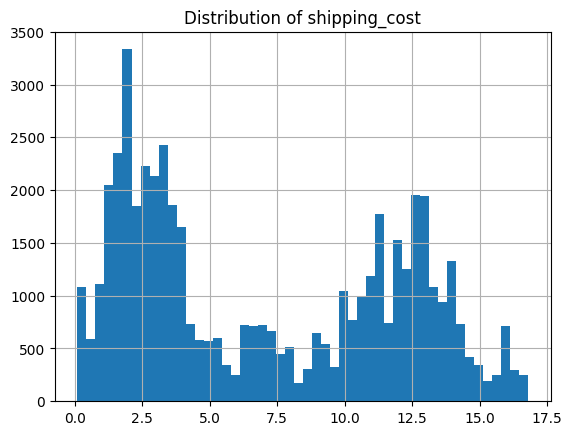

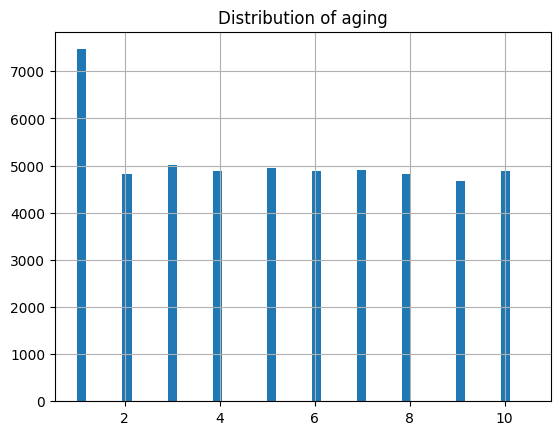

In [21]:
for col in num_cols:
    df[col].hist(bins=50)
    plt.title(f"Distribution of {col}")
    plt.show()

Observation: Most numeric columns are approximately symmetric, indicating balanced distributions

In [22]:
def detect_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return lower, upper


In [23]:
for col in num_cols:
    lower, upper = detect_outliers_iqr(df[col])
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    print(f"{col}: {outliers.shape[0]} outliers")

sales: 0 outliers
quantity: 0 outliers
discount: 0 outliers
profit: 0 outliers
shipping_cost: 0 outliers
aging: 0 outliers


Observation: No statistically significant outliers were detected using the IQR method

Conclusion: The results showed well-balanced distributions and no significant outliers, indicating stable transactional behavior. The final dataset is clean, reliable, and ready for further analysis or modeling.

In [ ]:
df.to_csv()